In [2]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from matplotlib.legend_handler import HandlerLine2D
import lmoments
from matplotlib.pylab import rcParams
import warnings as _warnings
from collections import OrderedDict
from numpy.random import randint as _randint
import lmoments
from pdb import set_trace as stop
from scipy import stats
from scipy.optimize import curve_fit
from scipy.stats import genextreme as gev
from pyextremes import get_extremes
from pyextremes.plotting import plot_extremes
from statsmodels.graphics.tsaplots import plot_acf
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from scipy.stats import gaussian_kde
from scipy.stats import zscore
from scipy.spatial import distance, distance_matrix
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering
from sklearn.datasets import load_iris
from scipy.cluster import hierarchy


In [3]:
stazioni = ["andria", "bari", "barletta_casardi", 
            "brindisi", "brindisi_sisri", "candela_ex_comes", 
            "carbonara", "casamassima", "cisternino", "foggia", 
            "francavilla_fontana", "galatina", "grottaglie", 
            "lecce", "lecce_cerrate", "maglie", "manfredonia_liceo", 
            "massafra", "molfetta", "monopoli", "san_pancrazio_salentino", 
            "san_severo", "taranto", "taranto_san_vito", "torchiarolo"]

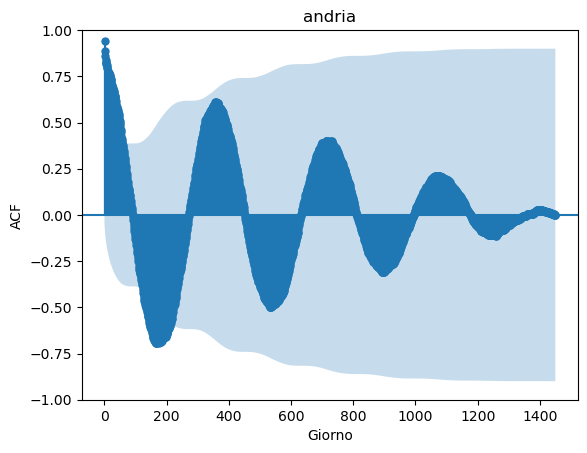

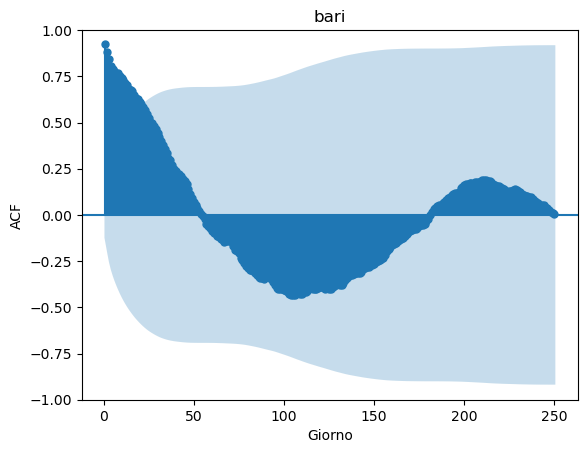

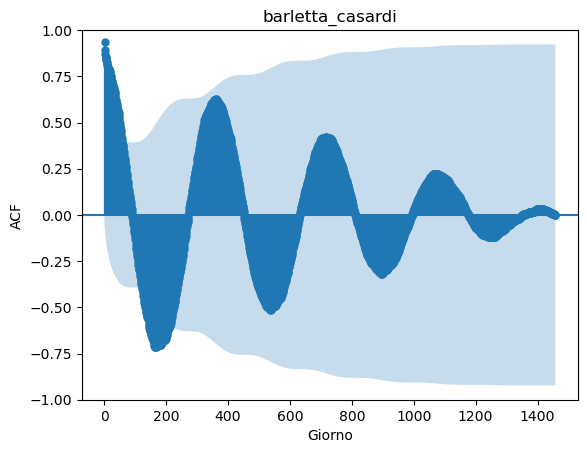

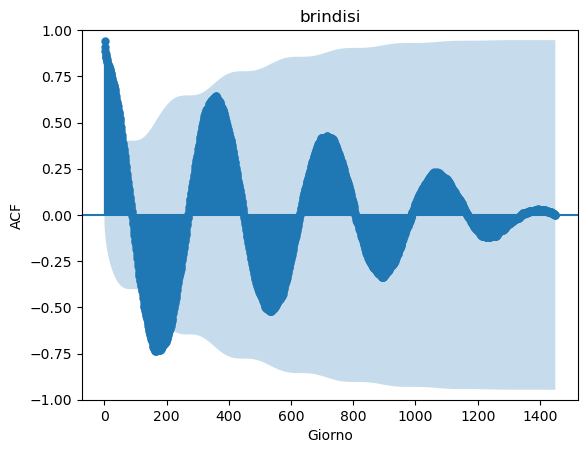

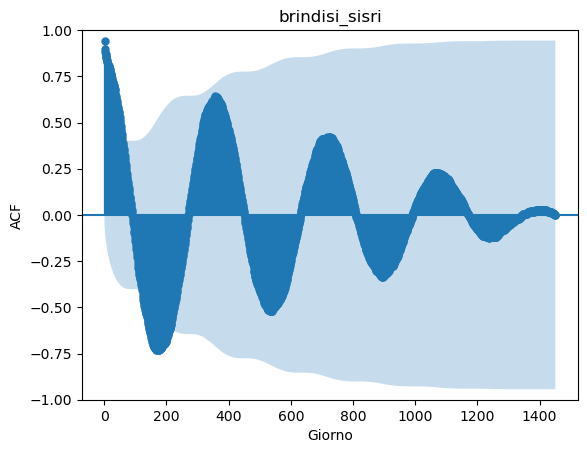

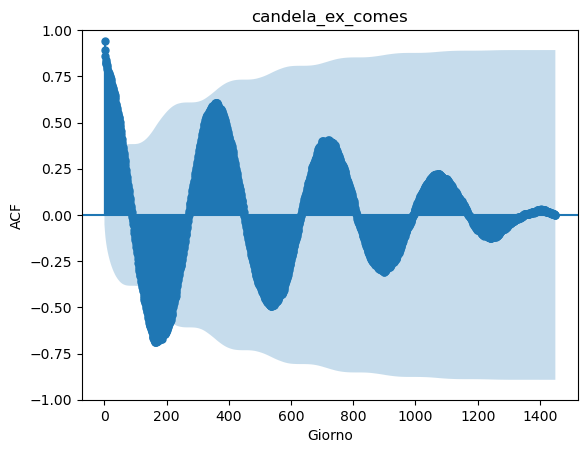

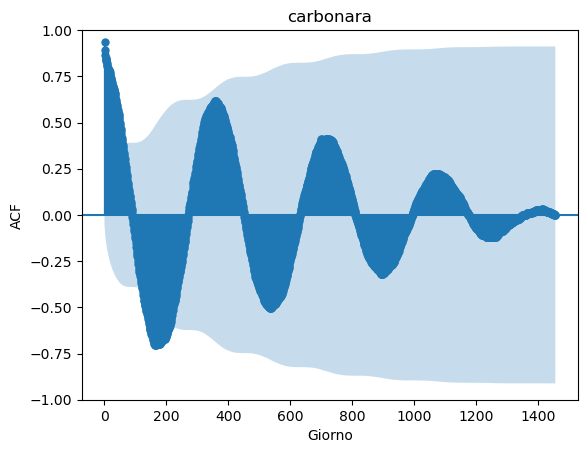

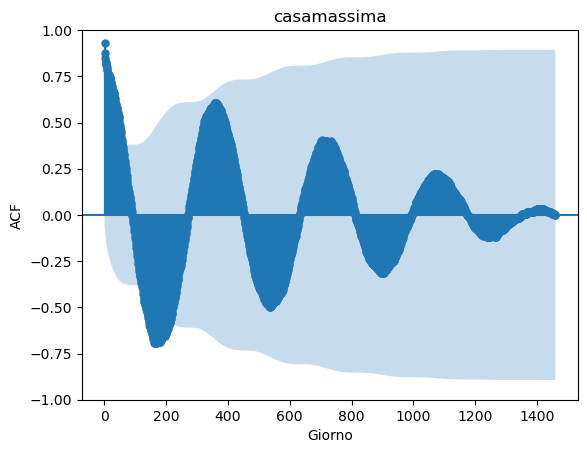

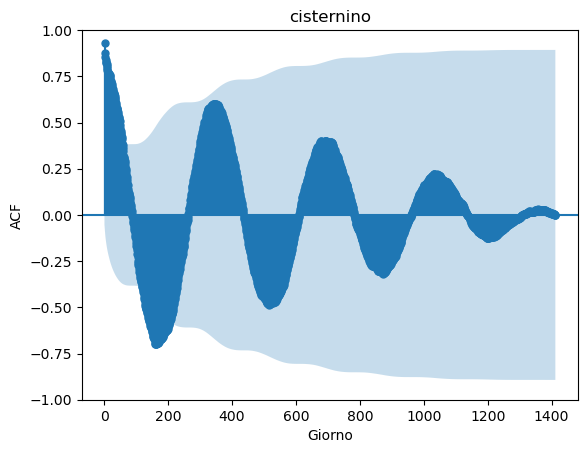

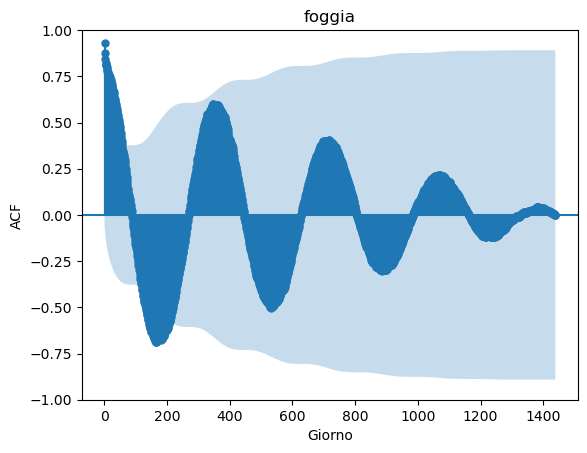

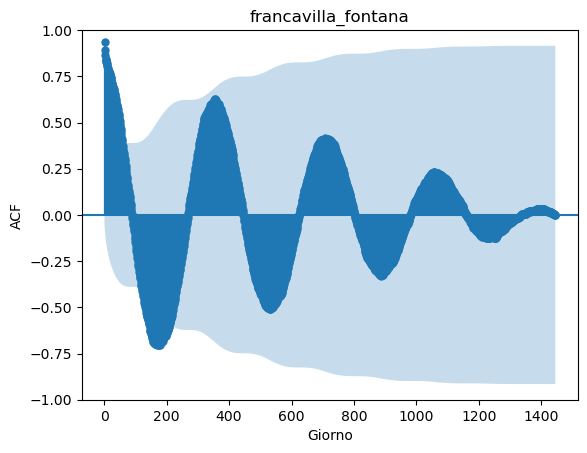

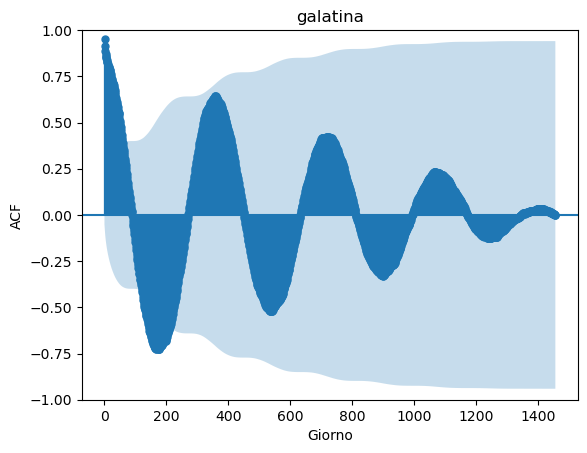

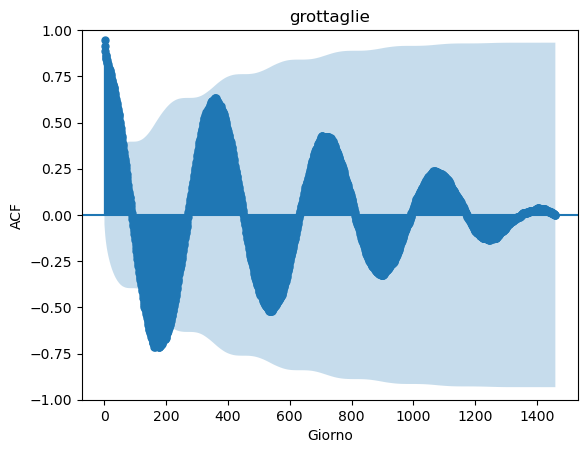

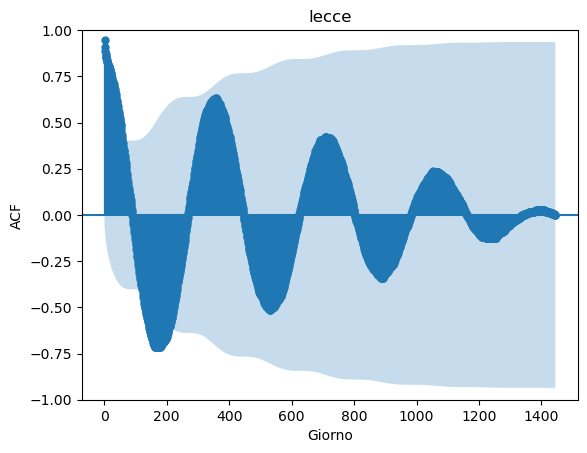

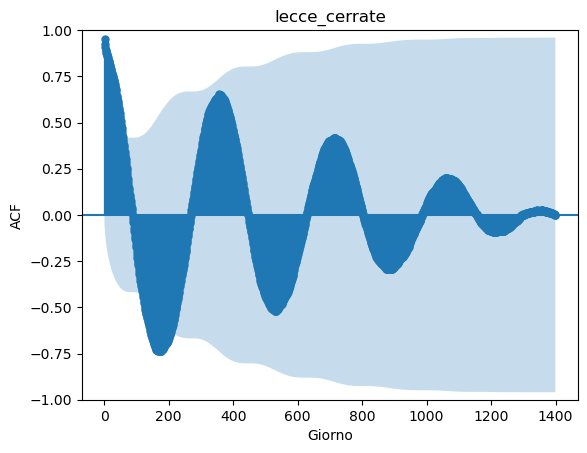

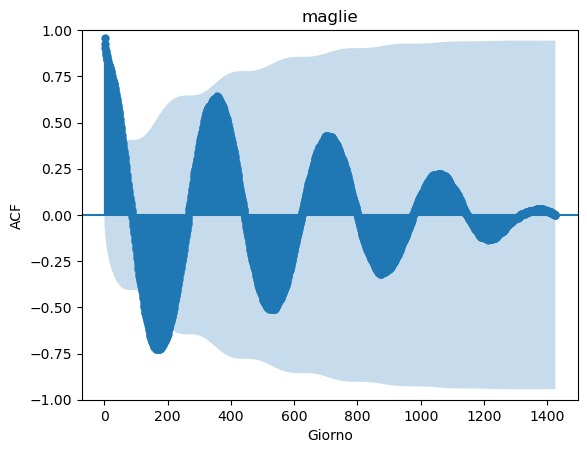

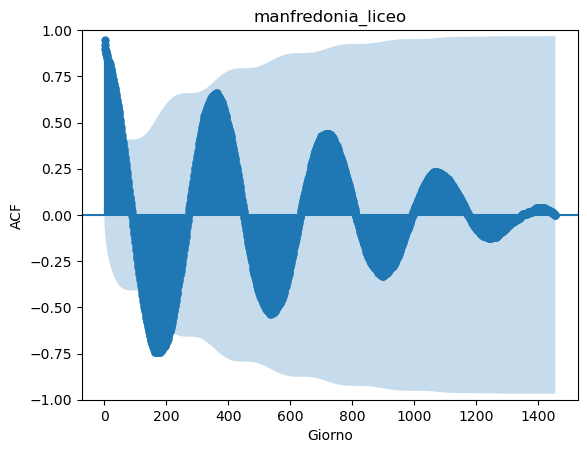

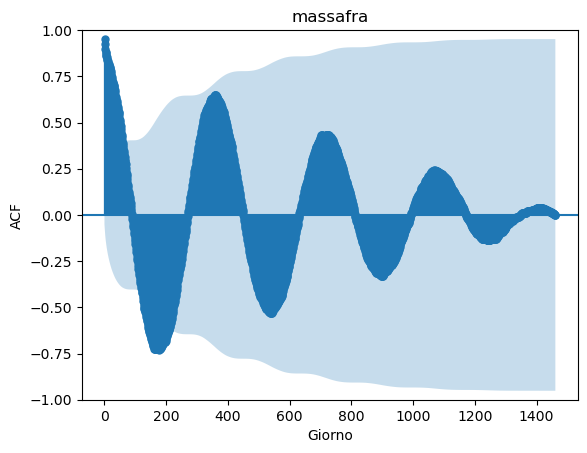

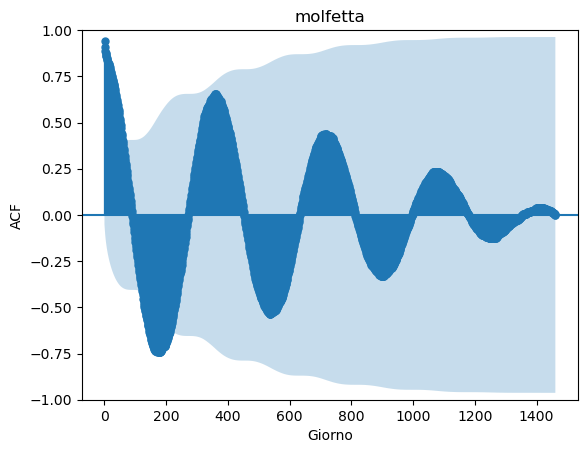

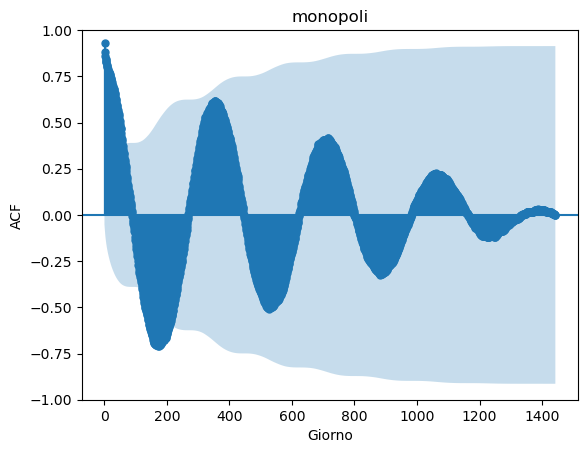

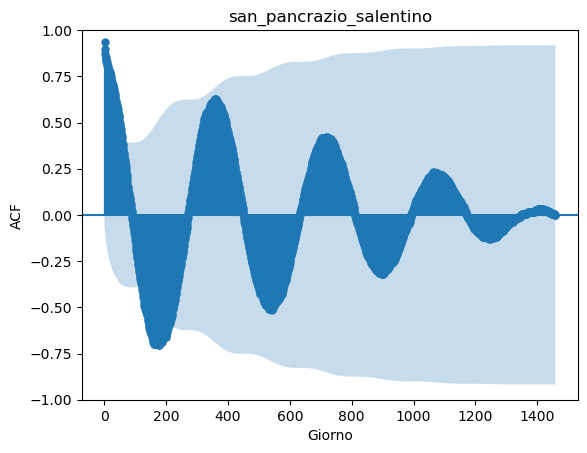

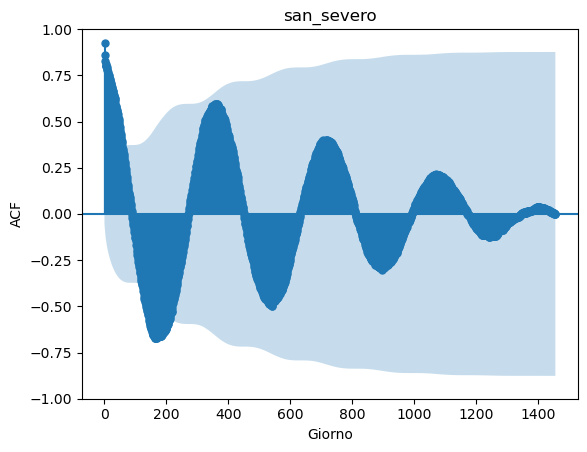

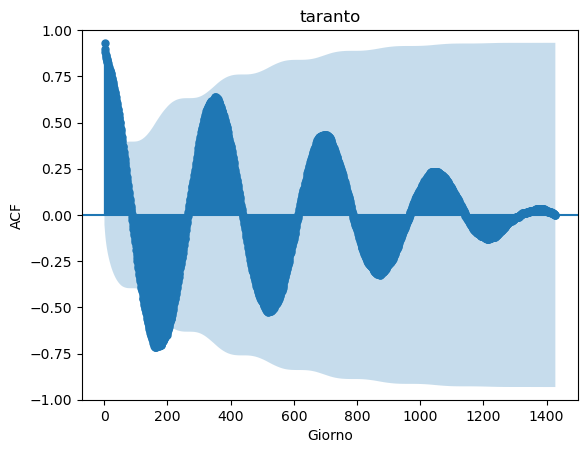

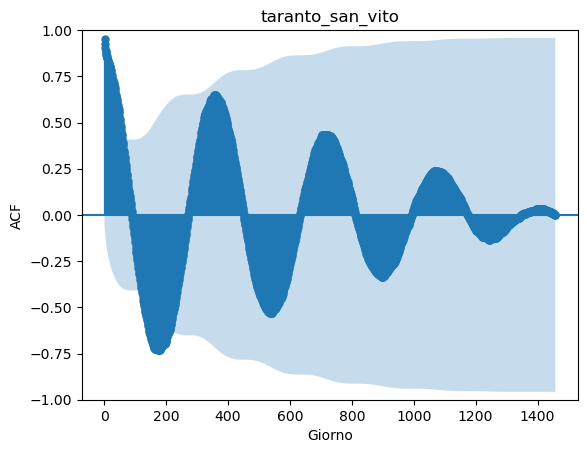

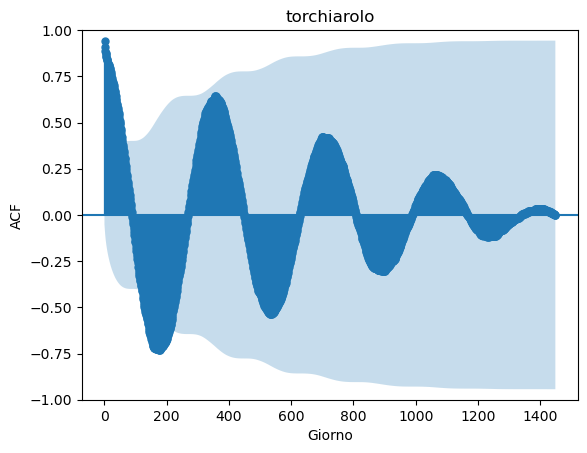

In [4]:
#lecture data
for i in range (0, len(stazioni)):
    path = f"/Users/reginacastrovilli/paper/Data_Max_Min/{stazioni[i]}.csv"
    file = pd.read_csv(path,sep=";")
    dat_0 = file['temperatura_max']
    x = dat_0.dropna()
    plot_acf(x, lags=range(1, len(x)))
    plt.title(stazioni[i])
    plt.xlabel('Giorno')
    plt.ylabel('ACF') 
    plt.show()
    plt.savefig(f"/Users/reginacastrovilli/paper/Grafici/acf_senza_low/temperature/{stazioni[i]}.pdf", format = 'pdf')


In [5]:
shape_values = []
loc_values = []
scale_values = []  

for i in range (0, len(stazioni)):
    path = f"/Users/reginacastrovilli/paper/Data_Max_Min/{stazioni[i]}.csv"
    file = pd.read_csv(path,sep=";")
    dat_0 = file['temperatura_max']
    y = dat_0.dropna()
    
    #for the lowess
    x = np.array(list(range(0, len(y))))

    lowess = sm.nonparametric.lowess(y, x, frac=0.003) 
    # Estrai i risultati LOESS
    lowess_x, lowess_y = lowess.T
    
    X_low = y - lowess_y

    # Inizializza le liste per gli shape, i loc e gli scale
    shape, loc, scale = stats.genextreme.fit(X_low)
    #shape, loc e scale sono calcolati per dati-loess
    
    # Aggiungere i valori correnti alle rispettive liste
    shape_values.append(shape)
    loc_values.append(loc)
    scale_values.append(scale)



# Conversione delle liste in array NumPy
shape_values = np.array(shape_values)
loc_values = np.array(loc_values)
scale_values = np.array(scale_values)

shape_values



/Users/reginacastrovilli/.conda/envs/pytorch/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:409: RuntimeWarning: invalid value encountered in scalar divide
  return m3 / np.power(m2, 1.5)


array([ 0.19786363, -0.77398732,  3.34450149,  0.19992736,  0.16791151,
        0.21065077,  0.20200161,  0.17377773,  0.21167685,  0.23933764,
        0.18147406,  0.22908578,  0.21299579,  0.22829292,  0.17669451,
        0.23437588,  0.20091573,  0.22487755,  0.17075333,  0.15712151,
        0.22165236,  0.18682346,  0.18647051,  0.21986387,  0.21406121])

In [6]:
mean_shape = np.mean(shape_values)
std_shape = np.std(shape_values)
mean_loc = np.mean(loc_values)
std_loc = np.std(loc_values)
mean_scale = np.mean(scale_values)
std_scale = np.std(scale_values)


In [7]:
shape_values

array([ 0.19786363, -0.77398732,  3.34450149,  0.19992736,  0.16791151,
        0.21065077,  0.20200161,  0.17377773,  0.21167685,  0.23933764,
        0.18147406,  0.22908578,  0.21299579,  0.22829292,  0.17669451,
        0.23437588,  0.20091573,  0.22487755,  0.17075333,  0.15712151,
        0.22165236,  0.18682346,  0.18647051,  0.21986387,  0.21406121])

In [8]:
zscore_shape = zscore(shape_values)
zscore_loc = zscore(loc_values)
zscore_scale = zscore(scale_values)
len(zscore_shape)

25

In [9]:
residual_matrix = np.vstack((zscore_shape, zscore_loc, zscore_scale))
residual_matrix_df = pd.DataFrame(residual_matrix.T, columns = ['zscore shape', 'zscore loc', 'z score scale'])


matrix_parameter = np.vstack((shape_values, loc_values, scale_values, zscore_shape, zscore_loc, zscore_scale))
matrix_parameter_df = pd.DataFrame(matrix_parameter.T, columns=['shape', 'loc', 'scale', 'zscore shape', 'zscore_loc', 'zscore_scale'])

distances = distance_matrix(residual_matrix_df.values, residual_matrix_df.values)
ytdist = pd.DataFrame(distances, index = residual_matrix_df.index, columns= residual_matrix_df.index)

ytdist.to_csv("/Users/reginacastrovilli/paper/parameter/parameter_temp/distances.csv", sep= ";", index = False)

In [11]:
if 'output_df_zscore_Gev' not in locals():
    output_df_zscore_Gev = pd.DataFrame(columns=['zscore shape', 'zscore_loc', 'zscore_scale'])

# Concatena i due DataFrame
output_df_zscore_Gev = pd.concat([output_df_zscore_Gev, residual_matrix_df], ignore_index=True)
output_df_zscore_Gev.to_csv("/Users/reginacastrovilli/paper/parameter/parameter_temp/residual.csv", sep=";", index=False)

In [13]:
if 'output_df_par_Gev' not in locals():
    output_df_par_Gev = pd.DataFrame(columns=['shape', 'loc', 'scale', 'zscore shape', 'zscore_loc', 'zscore_scale'])

# Concatena i due DataFrame
output_df_par_Gev = pd.concat([output_df_par_Gev, matrix_parameter_df], ignore_index=True)
output_df_par_Gev.to_csv("/Users/reginacastrovilli/paper/parameter/parameter_temp/parameter.csv", sep=";", index=False)


In [241]:
ytdist


,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,0.000000,4.525473,7.019032,0.391442,0.362051,0.162574,0.030433,0.358100,0.457110,1.012468,...,1.732357,0.193190,0.098381,0.157602,0.388507,0.743416,1.011295,0.080382,0.764708,0.508490
1,4.525473,0.000000,8.820979,4.159052,4.171963,4.682676,4.542100,4.852079,4.965043,5.507069,...,2.974692,4.345265,4.621362,4.655882,4.143598,5.242822,5.485714,4.453308,3.825623,5.015218
2,7.019032,8.820979,0.000000,6.992605,7.017813,7.042114,6.997965,7.091099,7.054296,7.171803,...,7.017972,6.993606,7.014549,7.072756,7.023109,7.115828,7.220726,6.999265,6.957619,7.080756
3,0.391442,4.159052,6.992605,0.000000,0.060441,0.551286,0.408075,0.748644,0.848206,1.402885,...,1.341135,0.198857,0.480068,0.544834,0.069405,1.134317,1.402496,0.324343,0.373949,0.899386
4,0.362051,4.171963,7.017813,0.060441,0.000000,0.523566,0.378523,0.715362,0.818186,1.373957,...,1.376197,0.173578,0.455330,0.511026,0.030069,1.104719,1.370591,0.291372,0.412690,0.869892
5,0.162574,4.682676,7.042114,0.551286,0.523566,0.000000,0.153288,0.206117,0.299908,0.851815,...,1.891316,0.354178,0.075778,0.063241,0.550158,0.583553,0.852319,0.240364,0.923837,0.348688
6,0.030433,4.542100,6.997965,0.408075,0.378523,0.153288,0.000000,0.344611,0.441264,0.997805,...,1.747771,0.209235,0.091729,0.148971,0.404643,0.728526,0.996935,0.089495,0.780206,0.494101
7,0.358100,4.852079,7.091099,0.748644,0.715362,0.206117,0.344611,0.000000,0.117203,0.662099,...,2.089704,0.550839,0.280911,0.204835,0.740002,0.393247,0.655345,0.428578,1.122380,0.163939
8,0.457110,4.965043,7.054296,0.848206,0.818186,0.299908,0.441264,0.117203,0.000000,0.557246,...,2.188129,0.649610,0.371655,0.312319,0.843675,0.287726,0.557259,0.528431,1.220440,0.058793
9,1.012468,5.507069,7.171803,1.402885,1.373957,0.851815,0.997805,0.662099,0.557246,0.000000,...,2.741641,1.205041,0.923349,0.865024,1.399604,0.269694,0.080758,1.085358,1.774528,0.504097


/var/folders/v8/0qypfq0n1vz50g1zdkphd9680000gn/T/ipykernel_70709/1360459968.py:3: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage_matrix = linkage(ytdist.values, method="complete")


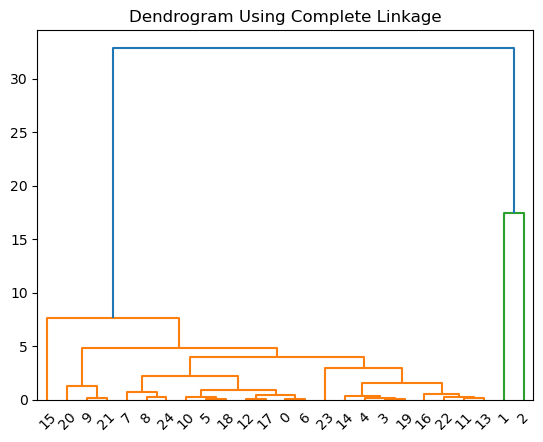

In [14]:
# Calcola il linkage e plotta il dendrogramma

linkage_matrix = linkage(ytdist.values, method="complete")

dendrogram(linkage_matrix, labels=residual_matrix_df.index)

plt.title("Dendrogram Using Complete Linkage")
plt.savefig("/Users/reginacastrovilli/paper/parameter/parameter_temp/dendogram_temp.pdf", format="pdf")

plt.show()

#warning: method="complete" sta cercando di calcolare nuovamente le distanze, ma scopre che hai già fornito una matrice di distanza
